# Image Stitching (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Stitching Pairs of Images section of MP 3. In main function, we outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- `opencv`
- `numpy`
- `skimage`
- `scipy`

# Common imports

In [1]:
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy
from copy import deepcopy
import math
from skimage.transform import ProjectiveTransform, warp

# Helper functions

In [2]:
def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)

def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

# Your implementations

In [3]:
def get_best_matches(img1, img2, thresh_ratio):
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1_x, kp1_y, kp2_x, kp2_y = np.array([kp.pt[0] for kp in kp1]), np.array([kp.pt[1] for kp in kp1]),\
        np.array([kp.pt[0] for kp in kp2]), np.array([kp.pt[1] for kp in kp2])
    # Find distance between descriptors in images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    # Write your code to get the matches according to dist
    # <YOUR CODE>
    distance_max = np.max(dist)
    distance_min = np.min(dist)
    distance_threshold = distance_min + (distance_max - distance_min) * thresh_ratio
    filtered_dist = np.where(dist < distance_threshold)
    # print(filtered_dist)
    rows, cols = filtered_dist
    selected_kp1_x, selected_kp1_y = kp1_x[rows], kp1_y[rows]
    selected_kp2_x, selected_kp2_y = kp2_x[cols], kp2_y[cols]
    matched_kp = np.column_stack((selected_kp1_x, selected_kp1_y, selected_kp2_x, selected_kp2_y))
    return matched_kp

def ransac(matched_kp, iter_num, inlier_threshold):
    """
    write your ransac code to find the best model, inliers, and residuals
    """
    N = matched_kp.shape[0]
    model_trans = None
    residual_error = None
    model_inliers = np.zeros((0, 4))
    for i in range(iter_num):
        # <YOUR CODE>
        matched_kp_tmp = deepcopy(matched_kp)
        matched_kp_tmp = deepcopy(matched_kp)
        indices = np.random.choice(N, 4, replace=False)
        ransac_kp = matched_kp[indices]
        trans = compute_homography(ransac_kp)
        matched_kp_first = matched_kp_tmp[:, :2]
        last_col = np.ones((matched_kp_first.shape[0], 1))
        matched_kp_first = np.column_stack((matched_kp_first, last_col))
        transed_kp = (trans@matched_kp_first.T).T
        error = (transed_kp - np.column_stack((matched_kp_tmp[:, 2:], last_col))) ** 2
        error = error.sum(axis=1)
        inlier = matched_kp[np.where(error < inlier_threshold)]
        if inlier.shape[0] > model_inliers.shape[0]:
            model_trans = trans 
            residual_error = error[np.where(error < inlier_threshold)]
            model_inliers = inlier
        # model_trans = cv2.findHomography(model_inliers[:, :2], model_inliers[:, 2:])[0]
    return model_trans, model_inliers, residual_error

def compute_homography(kp):
    """
    write your code to compute homography according to the matches
    kp: (4 * 4) x1, y1, x1', y1'
    """
    # <YOUR CODE>
    origin_kp = kp[:, :2]
    target_kp = kp[:, 2:]
    
    H = np.zeros((2 * kp.shape[0], 9))
    for i in range(kp.shape[0]):
        H[2 * i] = np.array([-origin_kp[i][0], -origin_kp[i][1], -1, 0, 0, 0, origin_kp[i][0] * target_kp[i][0], origin_kp[i][1] * target_kp[i][0], target_kp[i][0]])
        H[2 * i + 1] = np.array([0, 0, 0, -origin_kp[i][0], -origin_kp[i][1], -1, origin_kp[i][0] * target_kp[i][1], origin_kp[i][1] * target_kp[i][1], target_kp[i][1]])
    
    U, S, V = np.linalg.svd(H)
    V = V[-1:].reshape(3, 3)
    return V / V[-1, -1]

def warp_images(img1, img2, trans):
    """
    write your code to stitch images together according to the homography
    """
    projection = ProjectiveTransform(trans)
    # corners_1 = np.array([[0,0,1], [0, img1.shape[0], 1], [img1.shape[1], 0, 1], [img1.shape[1], img1.shape[0], 1]])
    # corners_2 = np.array([[0,0], [0, img2.shape[0]], [img2.shape[1], 0], [img2.shape[1], img2.shape[0]]])
    corners_1 = np.array([[0,0], [0, img1.shape[0],], [img1.shape[1], 0,], [img1.shape[1], img1.shape[0],]])
    corners_2 = np.array([[0,0, 1], [0, img2.shape[0], 1], [img2.shape[1], 0, 1], [img2.shape[1], img2.shape[0], 1]])
    wrap_corner = projection(corners_2[:, :2])
    wrap_corner = np.vstack((wrap_corner, corners_1))
    min_corner = np.min(wrap_corner, axis=0)
    max_corner = np.max(wrap_corner, axis=0)
    output_shape_x, output_shape_y = int(max_corner[1] - min_corner[1]), int(max_corner[0] - min_corner[0])
    output_shape = (output_shape_x, output_shape_y)
    wrap_img = np.zeros((output_shape_x, output_shape_y, 3))
    for i in range(3):
        wrap_img[:, :, i] = warp(img2[:, :, i], inverse_map=projection, output_shape=output_shape)
    for i in range(3):
        mask = wrap_img[:, :, i] == 0
        wrap_img[:, :, i][mask] = warp(img1[:, :, i], inverse_map=np.eye(3), output_shape=output_shape)[mask]

    return wrap_img

# Main functions

#### Load images

In [4]:
img1 = imread('./stitch/left.jpg')
img2 = imread('./stitch/right.jpg')

#### Part (3) compute and display the initial SIFT matching result

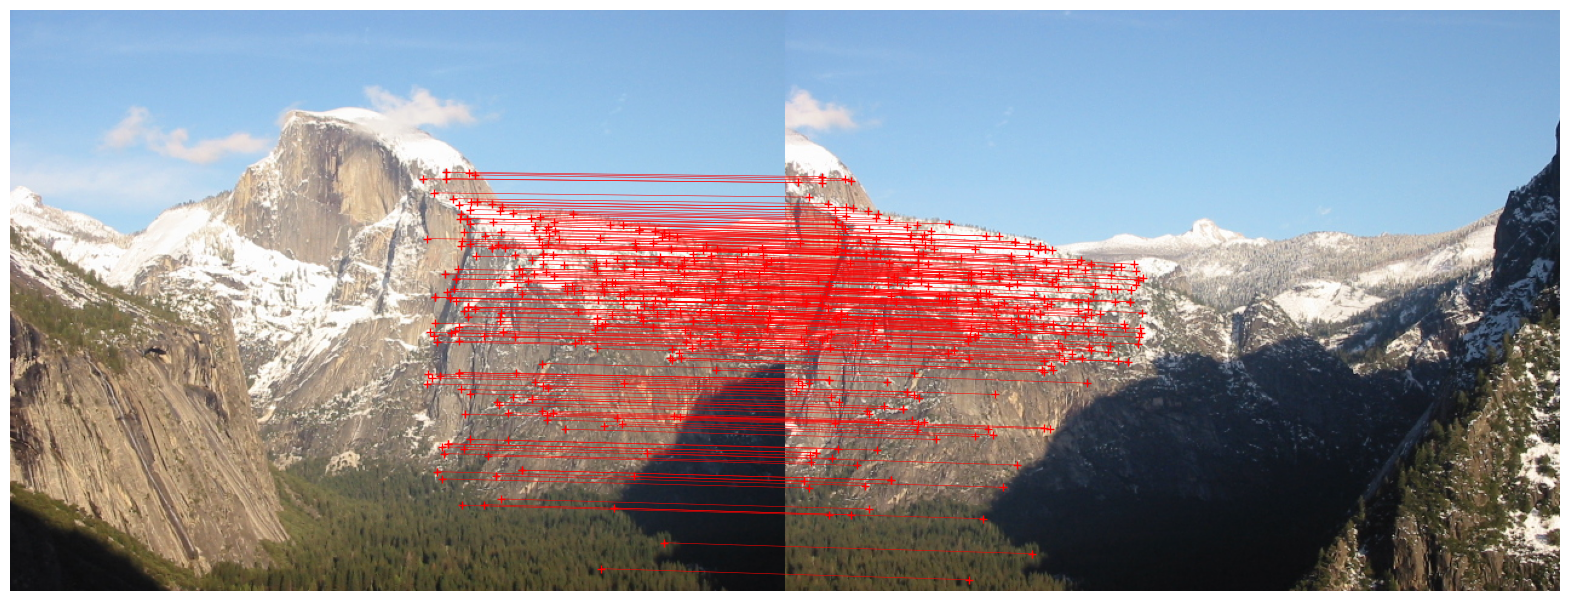

In [5]:
data = get_best_matches(img1, img2, 0.01)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)
fig.savefig('sift_match.png', bbox_inches='tight')

#### Part (4) performn RANSAC to get the homography and inliers

In [17]:
iter_num = 3
inlier_threshold = 100


Average residual: 41.912902871783366


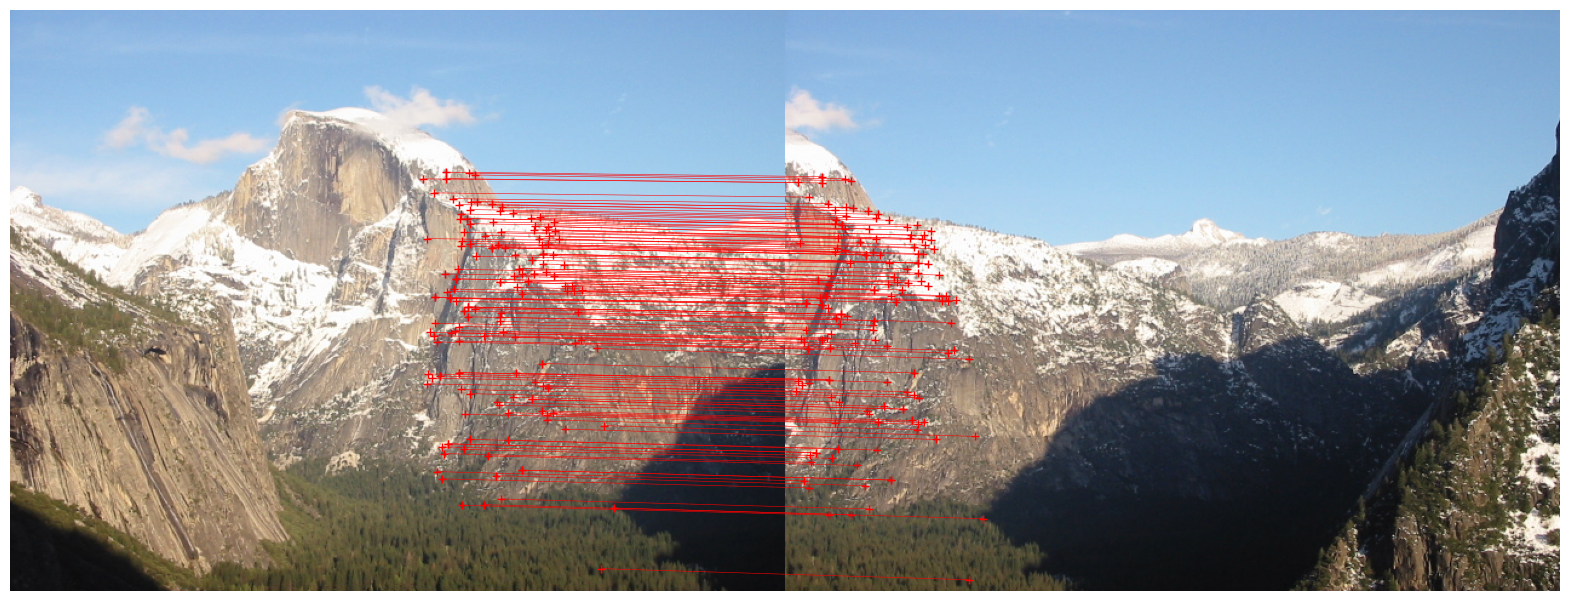

In [18]:
# display the inlier matching, report the average residual
# <YOUR CODE>
model_trans, max_inliers, best_model_errors = ransac(data, iter_num, inlier_threshold)
print("Average residual:", np.average(best_model_errors))
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, max_inliers)
fig.savefig('ransac_match.png', bbox_inches='tight')

#### Part (5) warp images to stitch them together

In [14]:
# display and report the stitching results
im = warp_images(img1, img2, model_trans)
cv2.imwrite('stitched_images.jpg', im[:,:,::-1]*255., 
            [int(cv2.IMWRITE_JPEG_QUALITY), 90])

True

## Extra Credit - blend image

In [50]:
from scipy.ndimage import gaussian_filter

levels = 10
sigma_windows = 2
sigma_img_stack = 3

def gaussian_img_stack(img, sigma, num_levels):
  img_stack = [img]
  dog_stack = []
  current_sigma = sigma
  for l in range(num_levels):
    # gaussian_windows = gaussian_filter1(current_sigma, 2 * windows_size + 1)
    # gaussian_img = scipy.signal.convolve2d(img_stack[l], gaussian_windows, mode="same", boundary="symm")
    gaussian_img = gaussian_filter(img_stack[l], current_sigma)
    
    dog = img_stack[l] - gaussian_img
    img_stack.append(gaussian_img)
    dog_stack.append(dog)
    current_sigma = current_sigma * np.sqrt(2)
  dog_stack.append(gaussian_img)
  return img_stack, dog_stack

def normalize(img):
  min_val = np.min(img)
  max_val = np.max(img)
  img = ((img - min_val) / (max_val - min_val) * 255).astype(np.uint8)
  
  return img

def blend(im1, im2, mask):
  im1 = np.array(im1, dtype=np.float32)*255
  im2 = np.array(im2, dtype=np.float32)
  
  mask = np.array(mask, dtype=np.float32)
  img1_gaussian_stack, img1_dog_stack = gaussian_img_stack(im1, sigma_img_stack, levels)
  img2_gaussian_stack, img2_dog_stack = gaussian_img_stack(im2, sigma_img_stack, levels)
  mask_gaussian, _ = gaussian_img_stack(mask, sigma_windows, levels)
  combined_gaussian = []
  out = np.zeros_like(mask_gaussian[-1])
  for l in range(levels):
    mask_gaussian[l] = mask_gaussian[l] / 255.
    img1_part = mask_gaussian[l] * img1_dog_stack[l]
    img2_part = (1 - mask_gaussian[l]) * img2_dog_stack[l]
    mean_img1_part = np.mean(img1_part)
    mean_img2_part = np.mean(img2_part)
    combined_img = img1_part  + img2_part * 1.3
    out += combined_img
  out = normalize(out)
  return out

In [34]:
def warp_blend_images(img1, img2, trans):
    """
    write your code to stitch images together according to the homography
    """
    
    projection = ProjectiveTransform(trans)
    
    corners_1 = np.array([[0,0,1], [0, img1.shape[0], 1], [img1.shape[1], 0, 1], [img1.shape[1], img1.shape[0], 1]])
    wrap_corner = projection(corners_1[:, :2])
    corners_2 = np.array([[0,0], [0, img2.shape[0]], [img2.shape[1], 0], [img2.shape[1], img2.shape[0]]])
    wrap_corner = np.vstack((wrap_corner, corners_2))
    min_corner = np.min(wrap_corner, axis=0)
    max_corner = np.max(wrap_corner, axis=0)
    output_shape_x, output_shape_y = int(max_corner[1] - min_corner[1]), int(max_corner[0] - min_corner[0])
    output_shape = (output_shape_x, output_shape_y)
    wrap_img = np.zeros((output_shape_x, output_shape_y, 3))
    for i in range(3):
        # wrap_img[:, :, i] = warp(img1[:, :, i], inverse_map=projection.inverse + translation, output_shape=output_shape)
        wrap_img[:, :, i] = warp(img2[:, :, i], inverse_map=projection, output_shape=output_shape)

    img1_extend = np.ones((output_shape_x, output_shape_y, 3))
    img1_extend[:img1.shape[0], :img1.shape[1],:] = img1

    overlap_x, overlap_y = img1.shape[0] + img2.shape[0] - wrap_img.shape[0], \
        img1.shape[1] + img2.shape[1] - wrap_img.shape[1]
    mask = np.zeros((output_shape_x, output_shape_y, 3))
    # mask[img1.shape[0] - overlap_x:, img1.shape[1] - overlap_y : , :] = 255
    mask[:, img1.shape[1] - overlap_y : , :] = 255
    blend_img = blend(wrap_img, img1_extend, mask)
    return blend_img

In [51]:
im = warp_blend_images(img1, img2, model_trans)
cv2.imwrite('blend_image2.jpg', im[:,:,::-1], 
            [int(cv2.IMWRITE_JPEG_QUALITY), 90])

True